In [151]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numba

In [152]:
# Model parameters
J = 1
LENGTH = 100
CRITICAL_TEMP = 2 / np.log(1 + np.sqrt(2))
BETA_CRITICAL = 1 / CRITICAL_TEMP
BETA_LIST = np.arange(0.4, 3 , 0.4) * BETA_CRITICAL

print(BETA_LIST)

[0.17627472 0.35254943 0.52882415 0.70509887 0.88137359 1.0576483
 1.23392302]


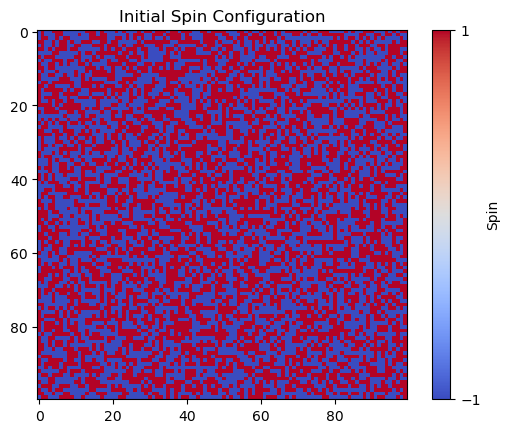

In [153]:
# Initial configuration

np.random.seed(69420)

SPIN_UP = 1
SPIN_DOWN = -1

# initial_configuration = np.zeros((LENGTH, LENGTH))
# for i in range(LENGTH):
#     for j in range(LENGTH):
#         tmp = np.random.randint(0, 2)
#         if tmp == 0 : 
#             tmp = SPIN_DOWN
#         else :
#             tmp = SPIN_UP    
#         initial_configuration[i,j] = tmp

initial_configuration = np.random.choice([SPIN_UP, SPIN_DOWN], size=(LENGTH, LENGTH))
np.random.seed(None) # in this way the initial configuration is set always in the same way, but the rest of the evolution no

plt.imshow(initial_configuration, cmap="coolwarm", interpolation="nearest")
cbar = plt.colorbar(ticks=[SPIN_DOWN, SPIN_UP])  # Set colorbar ticks to -1 and +1
cbar.set_label("Spin")
plt.title("Initial Spin Configuration")
plt.show()

Note that the system defines the mean quantites, but the equilibration times is dependent on the main configuration and on the run considered (same initial condition and same system can have different different equilibration times).

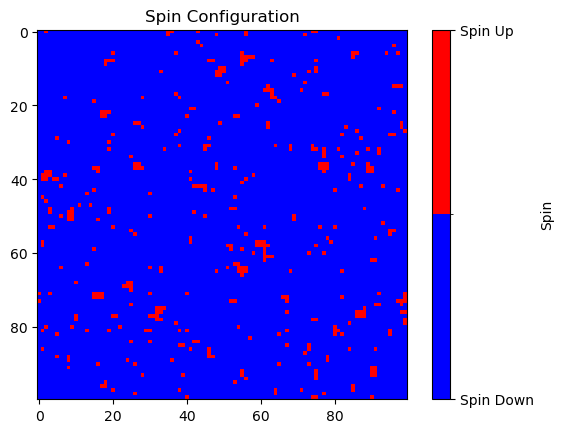

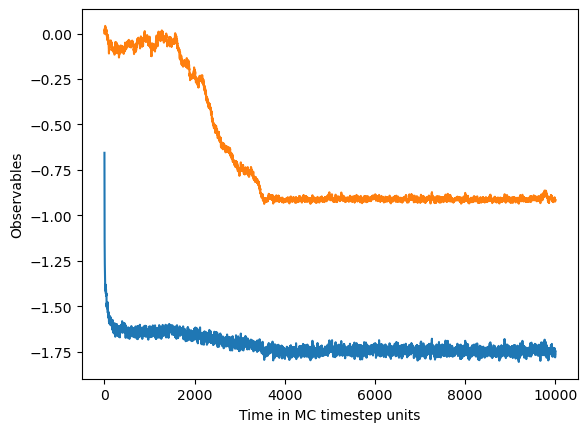

In [154]:
def neighbors_list_pbc():
    neighbors_list = {}
    for i in range(LENGTH):
        for j in range(LENGTH):
            neighbors = []
            # Apply periodic boundary conditions (PBC) with modulo operator
            neighbors.append(((i - 1) % LENGTH, j))  
            neighbors.append(((i + 1) % LENGTH, j))  
            neighbors.append((i, (j - 1) % LENGTH))  
            neighbors.append((i, (j + 1) % LENGTH))        
            neighbors_list[(i, j)] = neighbors           
    return neighbors_list

neighbors_list = neighbors_list_pbc() # the neighbor list is configuration independent and can be evaluated at the start of the procedure.   

def system_energy(configuration, neighbors_list):
    energy = 0 
    for (i, j), neighbors in neighbors_list.items():
        for neighbor in neighbors:
            neighbor_i, neighbor_j = neighbor
            energy -= J * configuration[i][j] * configuration[neighbor_i][neighbor_j]
    return energy / 2

def metropolis (old_configuration : np.ndarray, new_configuration : np.ndarray, beta : float) -> bool:
    delta_Energy=system_energy(new_configuration, neighbors_list) - system_energy(old_configuration, neighbors_list)
    if delta_Energy <= 0: return True
    elif np.random.random() <= np.exp(- beta * delta_Energy ) : return True
    return False            

def metropolis_spin_flip_dynamics (old_configuration, beta):
    i = np.random.randint(0, LENGTH)
    j = np.random.randint(0, LENGTH)
    neighbor_sum = sum(old_configuration[neighbor] for neighbor in neighbors_list[(i, j)])
    delta_energy = 2 * J * old_configuration[i,j] * neighbor_sum
    new_configuration= old_configuration.copy()
    new_configuration[i,j] = -old_configuration[i,j] # spin flip
    if delta_energy <= 0: return new_configuration
    elif np.random.random() <= np.exp(- beta * delta_energy ) : return new_configuration
    return old_configuration   

# def glauber_spin_flip_dynamics (old_configuration, beta):
#     i = np.random.randint(0, LENGTH)
#     j = np.random.randint(0, LENGTH)
#     neighbor_sum = sum(old_configuration[neighbor] for neighbor in neighbors_list[(i, j)])
#     delta_energy = 2 * J * old_configuration[i,j] * neighbor_sum
#     new_configuration= old_configuration.copy()
#     new_configuration[i,j] = -old_configuration[i,j] # spin flip
#     #if delta_energy <= 0: return new_configuration
#     if np.random.random() <= 1 / (1 + np.exp( beta * delta_energy )) : return new_configuration
#     return old_configuration

# def metropolis_spin_flip_timestep(old_configuration, beta):
#     config = old_configuration
#     for _ in range (LENGTH * LENGTH):
#         config = metropolis_spin_flip_dynamics(config, beta)
#     return config    

MC_TIMESTEPS = 10000
TIMESTEPS = LENGTH * LENGTH
beta = 1/ (0.881 * CRITICAL_TEMP)

configurations = np.zeros((MC_TIMESTEPS, LENGTH, LENGTH))
config = initial_configuration  # Initialize once outside the loop

for mc_step in range(MC_TIMESTEPS):
    for _ in range(TIMESTEPS):
        config = metropolis_spin_flip_dynamics(config, beta)
    configurations[mc_step] = config  # Save after each MC step

###################################
# Optional - GIF
###################################

# from PIL import Image, ImageDraw

# # Convert each frame to an image and add time text
# frames = []
# output_size = (350, 350)
# for i, frame in enumerate(configurations):
#     img = Image.fromarray(frame.astype(np.uint8)).convert("L")  # Convert to grayscale
#     img = img.resize(output_size, Image.NEAREST)  # Resize to desired output size
#     img = img.convert("RGB")  # Convert to RGB for colored text

#     # Draw the time (or frame index) on the image
#     draw = ImageDraw.Draw(img)
#     time_text = f"Time: {i}"  # or use a real time value if you have it
#     draw.text((10, 10), time_text, fill=(255, 0, 0))  # Position text in red

#     frames.append(img)

# frames[0].save('animated_with_time.gif', save_all=True, append_images=frames[1:], duration=60, loop=0)

##############################
##############################

# Define custom colormap: blue for -1 (spin down), red for 1 (spin up)
cmap = mcolors.ListedColormap(["blue", "red"])
bounds = [-1, 0, 1]  # Boundaries for -1, 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the final configuration with the custom colormap
plt.imshow(configurations[MC_TIMESTEPS-1], cmap=cmap, norm=norm, interpolation="nearest")
cbar = plt.colorbar(ticks=[-1, 1])  # Use -1 and 1 for spin down and up
cbar.set_label("Spin")
cbar.ax.set_yticklabels(["Spin Down", "Spin Up"])  # Label ticks accordingly
plt.title("Spin Configuration")
plt.show()

time = np.arange(0, MC_TIMESTEPS, 1)
energy_per_spin = np.zeros(MC_TIMESTEPS)
magnetization_per_spin = np.zeros(MC_TIMESTEPS)
for i in range(MC_TIMESTEPS):
    energy_per_spin[i] = system_energy(configurations[i], neighbors_list)
    magnetization_per_spin[i] = np.sum(configurations[i])
energy_per_spin = energy_per_spin / (LENGTH * LENGTH)
magnetization_per_spin = magnetization_per_spin / (LENGTH * LENGTH)
plt.plot(time, energy_per_spin, label = "energy per spin")
plt.plot(time, magnetization_per_spin, label = "magnetization per spin")
plt.xlabel("Time in MC timestep units")
plt.ylabel("Observables")
plt.show()
